# import lib

In [35]:
import networkx as nx
import random
import matplotlib.pyplot as plt
import fnss
import numpy as np
from itertools import islice

# Plot topology

In [4]:
def draw_topo_graph(topo_graph, outfile=None):
    """
    Uses matplotlib to draw the topology graph to the outfile. Uses different
    colors for the nodes if nodes have the attribute 'type' set to either
    'switch' or 'host'.
    
    Parameters
    ----------
    topo_graph: fnss.DatacenterTopology or networkx.Graph
      Input topology graph. Should be an object of type networkx.Graph OR fnss.DatacenterTopology
    outfile: string
      Path along with filename and extension to output the topology graph drawing
      
    Returns
    -------
    outfile: jpg, png, svg or pdf file depending on the file extension
      Draws the graph to the outfile.
    """

    switch_color = '#800000'
    host_color = '#808080'

    color_map = []
    for node,attributes in topo_graph.nodes.data():
        node_type = attributes.get('type')
        if node_type == 'switch':
            color_map.append(switch_color)
        elif node_type == 'host':
            color_map.append(host_color)

    if (len(color_map) > 0):
        nx.draw(topo_graph, node_color = color_map)   
    else:
        nx.draw(topo_graph)
    if outfile:
        plt.savefig(outfile)


# Fat Tree topology

In [5]:
def build_fattree_graph(k):
    """
    Uses the fnss library to build a fat tree topology with k-port switches
    
    Parameters
    ----------
    k: int
      Number of ports per fat tree switch
      
    Returns
    -------
    fnss.DatacenterTopology
    """
    return fnss.fat_tree_topology(k)

## figure 1(a)

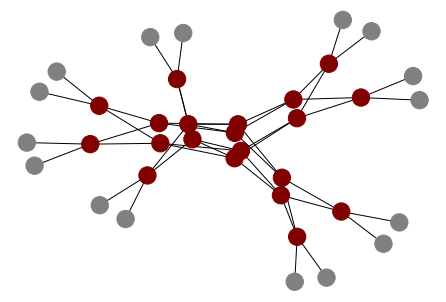

In [6]:
fat_tree_4 = build_fattree_graph(4)
# draw_topo_graph(fat_tree_4, "figure1(a).png")
draw_topo_graph(fat_tree_4)

# Jellyfish topology

In [76]:
def str_gt(s1, s2):
    num1 = int(s1.lstrip('s'))
    num2 = int(s2.lstrip('s'))
    return num1 > num2

def build_jellyfish_graph(num_racks, switch_degree, num_hosts_per_rack):
    """
    Uses the networkx library to build a JellyFish topology with given parameters
    
    Parameters
    ----------
    num_racks: int
      Total number of racks. Also, equivalent to the number of switches
      Called "N" in the JellyFish paper
    
    switch_degree: int
      Total number of ports per switch
      Called "k" in the JellyFish paper
      
    num_hosts_per_rack: int
      Total number of hosts (servers) per rack
      Called "(k - r)" in the JellyFish paper
      
    Returns
    -------
    networkx.Graph
      A JellyFish topology graph. Each node is tagged with an attribute called 'type'. 
      Possible values for 'type' are 'host' or 'switch'.
    """
    
    if num_racks * (switch_degree - num_hosts_per_rack) % 2 != 0:
        print("N * r must be even!")
        return None
    if not 0 <= switch_degree < num_racks:
        print("0 <= k < N must be satisfied!")
        return None
    if not 0 <= (switch_degree - num_hosts_per_rack) < num_racks:
        print("0 <= r < N must be satisfied!")
        return None
    
    # initialize
    graph = nx.Graph()
    
    # add switches and hosts
    switch_set = []
    for i in range(0, num_racks):
        switch_set.append('s%s' % i)
        graph.add_node('s%s' % i, type='switch')
    
    host_set = []
    for i in range(0, num_hosts_per_rack*num_racks):
        host_set.append('h%s' % i)
        graph.add_node('h%s' % i, type='host')
    
    # initialize switch set, using a dictionary. key: node. value: number of free ports.
    # remove k-v pair whose v=0
    switch_port_dict = {node: switch_degree - num_hosts_per_rack for node in graph.nodes if graph.nodes[node].get('type') == 'switch'}
#     print(switch_port_dict)
                
    switches = switch_port_dict.copy()
    while switches:
        # (x,y) -> (p1,x), (p2,y)
        if len(switches) == 1:
            node = list(switches.keys())[0]
            if switches[node] >= 2:
                choosable_switches = [s for s in switch_set if s != node]
                x = random.choice(choosable_switches)
                x_choosable_neighbors = [n for n in graph.neighbors(x) if n != node and graph.nodes[n].get('type') == 'switch']
                y = random.choice(x_choosable_neighbors)
                if str_gt(x, y):
                    x, y = y, x
                graph.remove_edge(x, y)
                if str_gt(x, node):
                    graph.add_edge(node, x)
                else:
                    graph.add_edge(x, node)
                if str_gt(y, node):
                    graph.add_edge(node, y)
                else:
                    graph.add_edge(y, node)  
                switches[node] -= 2
                if switches[node] == 0:
                    switches.pop(node)
                continue
                
        # randomly choose two switches and link them
        # restart the whole process when no switch-switch edge can be added to reduce the num of free ports
        restart = False
        while True:
            s1 = random.choice(list(switches.keys()))
            choosable_switches = [s for s in switches.keys() if s != s1 and s not in graph.neighbors(s1)]
            if not choosable_switches:
                restart = True
                for sw1 in switches.keys():
                    for sw2 in switches.keys():
                        if sw1 != sw2:
                            if sw2 not in graph.neighbors(sw1):
                                restart = False
                if restart:
                    break
            else:
                break
        
        if restart:
            switches = switch_port_dict.copy()
            graph.clear_edges()
            continue
            
        s2 = random.choice(choosable_switches)
        if str_gt(s1, s2):
            s1, s2 = s2, s1
        graph.add_edge(s1, s2)
        switches[s1] -= 1
        switches[s2] -= 1
        if switches[s1] == 0:
            switches.pop(s1)
        if switches[s2] == 0:
            switches.pop(s2)
        
    # add edge between switches and hosts
    for i in range(0, num_racks):
        for j in range(0, num_hosts_per_rack):
            graph.add_edge('s%s' % (i), 'h%s' % (i * num_hosts_per_rack + j))
            
    # add edge between switches and hosts
    while switch_set:
        sw = switch_set.pop(0)
        for _ in range(num_hosts_per_rack):
            host = host_set.pop(0)
            graph.add_edge(sw, host)

    return graph

In [77]:
g = build_jellyfish_graph(16, 4, 1)

## build jellyfish with the same equipment as fattree

In [78]:
def build_jellyfish_graph_identical_equipment_as_fattree(num_racks, num_racks_with_hosts, switch_degree, num_hosts_per_rack):
    """
    Uses the networkx library to build a JellyFish-like(same equipment as fat tree) topology with given parameters
    
    Parameters
    ----------
    num_racks: int
      Total number of racks. Also, equivalent to the number of switches
      Called "N" in the JellyFish paper
    
    num_racks_with_hosts: int
      Number of racks whose neighbors include hosts
    
    switch_degree: int
      Total number of ports per switch
      Called "k" in the JellyFish paper
      
    num_hosts_per_rack: int
      Total number of hosts (servers) per rack
      Called "(k - r)" in the JellyFish paper
      
    Returns
    -------
    networkx.Graph
      A JellyFish topology graph. Each node is tagged with an attribute called 'type'. 
      Possible values for 'type' are 'host' or 'switch'.
    """
    if (num_racks_with_hosts * (switch_degree - num_hosts_per_rack) + (num_racks - num_racks_with_hosts) * switch_degree) % 2 != 0:
        print("N * r must be even!")
        return None
    if not 0 <= switch_degree < num_racks:
        print("0 <= k < N must be satisfied!")
        return None
    if not 0 <= (switch_degree - num_hosts_per_rack) < num_racks:
        print("0 <= r < N must be satisfied!")
        return None
    
    # initialize
    graph = nx.Graph()
    
    # add switches and hosts
    switch_set = []
    for i in range(0, num_racks):
        switch_set.append('s%s' % i)
        graph.add_node('s%s' % i, type='switch')
    
    host_set = []
    for i in range(0, num_hosts_per_rack*num_racks_with_hosts):
        host_set.append('h%s' % i)
        graph.add_node('h%s' % i, type='host')
    
    # initialize switch set, using a dictionary. key: node. value: number of free ports.
    # remove k-v pair whose v=0
    switch_port_dict = {node: switch_degree - num_hosts_per_rack for node in graph.nodes if graph.nodes[node].get('type') == 'switch'}
    
    # randomly choose (num_racks - num_racks_with_hosts) switches without edges to hosts
    switches_no_hosts = random.sample(switch_set, num_racks - num_racks_with_hosts)
    for sw in switches_no_hosts:
        switch_port_dict[sw] = switch_degree
#     print(switch_port_dict)
                
    switches = switch_port_dict.copy()
    while switches:
        # (x,y) -> (p1,x), (p2,y)
        if len(switches) == 1:
            node = list(switches.keys())[0]
            if switches[node] >= 2:
                choosable_switches = [s for s in switch_set if s != node]
                x = random.choice(choosable_switches)
                x_choosable_neighbors = [n for n in graph.neighbors(x) if x != node and graph.nodes[n].get('type') == 'switch']
                y = random.choice(x_choosable_neighbors)
                if str_gt(x, y):
                    x, y = y, x
                graph.remove_edge(x, y)
                if str_gt(x, node):
                    graph.add_edge(node, x)
                else:
                    graph.add_edge(x, node)
                if str_gt(y, node):
                    graph.add_edge(node, y)
                else:
                    graph.add_edge(y, node)  
                switches[node] -= 2
                if switches[node] == 0:
                    switches.pop(node)
                continue
                
        # randomly choose two switches and link them
        # restart the whole process when no switch-switch edge can be added to reduce the num of free ports
        restart = False
        while True:
            s1 = random.choice(list(switches.keys()))
            choosable_switches = [s for s in switches.keys() if s != s1 and s not in graph.neighbors(s1)]
            if not choosable_switches:
                restart = True
                for sw1 in switches.keys():
                    for sw2 in switches.keys():
                        if sw1 != sw2:
                            if sw2 not in graph.neighbors(sw1):
                                restart = False
                if restart:
                    break
            else:
                break
        
        if restart:
            switches = switch_port_dict.copy()
            graph.clear_edges()
            continue
            
        s2 = random.choice(choosable_switches)
        if str_gt(s1, s2):
            s1, s2 = s2, s1
        graph.add_edge(s1, s2)
        switches[s1] -= 1
        switches[s2] -= 1
        if switches[s1] == 0:
            switches.pop(s1)
        if switches[s2] == 0:
            switches.pop(s2)
        
    # add edge between switches and hosts
    while switch_set:
        sw = switch_set.pop(0)
        if sw not in switches_no_hosts:
            for _ in range(num_hosts_per_rack):
                host = host_set.pop(0)
                graph.add_edge(sw, host)

    return graph

## figure 1(b)

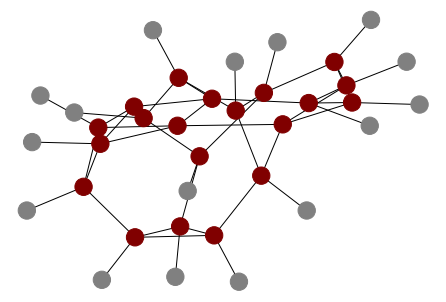

In [79]:
jellyfish_like = build_jellyfish_graph_identical_equipment_as_fattree(20, 16, 4, 1)
# draw_topo_graph(jellyfish_like, "figure1(b).png")
draw_topo_graph(jellyfish_like)

# Path length distribution

In [10]:
def path_length_stat(graph, return_percentage=True):
    host_set = list()
    other_set = list()
    for k,v in graph.nodes.data():
        if v['type'] == 'host':
            host_set.append(k)
        else:
            other_set.append(k)
    stat = {}
    for h in host_set:
        p = nx.single_source_shortest_path_length(graph, h)
        for node in other_set:
            p.pop(node)
        for _, v in p.items():
            if v not in stat:
                stat[v] = 0
            stat[v] += 1
    if 0 in stat:
        stat.pop(0)
    
    if return_percentage:
        s = 0
        for _, v in stat.items():
            s += v
        for k, v in stat.items():
            stat[k] = v / s
    return stat

def path_length_stat_10_means(build_graph, **kwargs):
    stat = {}
    for _ in range(10):
        graph = build_graph(**kwargs)
        one_graph_stat = path_length_stat(graph, return_percentage=False)
        for k, v in one_graph_stat.items():
            if k not in stat:
                stat[k] = 0
            stat[k] += v
        
    s = 0
    for _, v in stat.items():
        s += v
    for k, v in stat.items():
        stat[k] = v / s
    return stat

## one graph path distribution

fat tree k=14

In [11]:
fat_tree_14 = build_fattree_graph(14)
path_distribution_ft14 = path_length_stat(fat_tree_14)
print(path_distribution_ft14)

{2: 0.008759124087591242, 4: 0.061313868613138686, 6: 0.92992700729927}


jellyfish-like N=245, num_racks_with_hosts=230, k=14, num_hosts_per_racks=3

In [12]:
jellyfish_686 = build_jellyfish_graph_identical_equipment_as_fattree(245, 230, 14, 3)
path_distribution_jf686 = path_length_stat(jellyfish_686)
print(path_distribution_jf686)

{2: 0.002902757619738752, 3: 0.04414715719063545, 4: 0.3629456679497697, 5: 0.5862939357607118, 6: 0.0037104814791443174}


## 10 graphs path distribution

In [13]:
fattree_14_10_means = path_length_stat_10_means(build_fattree_graph, k=14)
print(fattree_14_10_means)

{2: 0.008759124087591242, 4: 0.061313868613138686, 6: 0.92992700729927}


In [14]:
jellyfish_686_10_means = path_length_stat_10_means(build_jellyfish_graph_identical_equipment_as_fattree,
                                                   num_racks=245, num_racks_with_hosts=230, 
                                                   switch_degree=14, num_hosts_per_rack=3)
print(jellyfish_686_10_means)

{2: 0.002902757619738752, 3: 0.04422288130245473, 4: 0.3602650343913675, 5: 0.588137817883511, 6: 0.004471508802927999}


## figure 1 (c)

In [15]:
def draw_path_stat(fattree_14_10_means, jellyfish_686_10_means, outfile=None):
    fig, ax = plt.subplots(figsize=(10,5)) # init figure with landscape aspect ratio

    x = []

    for k in fattree_14_10_means.keys():
        if k not in x:
            x.append(k)
    for k in jellyfish_686_10_means.keys():
        if k not in x:
            x.append(k)

    x = np.array(x)
    x = np.sort(x)

    fattree14_y = []
    jellyfish686_y = []

    for each in x:
        if each in fattree_14_10_means:
            fattree14_y.append(fattree_14_10_means[each])
        else:
            fattree14_y.append(0)
        if each in jellyfish_686_10_means:
            jellyfish686_y.append(jellyfish_686_10_means[each])
        else:
            jellyfish686_y.append(0)

    bar_width = 0.3

    # Bars for fattree
    ax.bar(x + bar_width, fattree14_y, label='Fat-tree', align='center', 
           edgecolor='black', width=0.3, linewidth=1, hatch="xx", 
           color="white")

    # Bars for jellyfish
    ax.bar(x, jellyfish686_y, label='Jellyfish', align='center', 
           edgecolor='black', width=0.3, linewidth=1,
           color="#00008B")

    plt.xlabel('Path length', fontsize=15)
    plt.ylabel('Fraction of Server Pairs', fontsize=15)

    # y ranges from 0.0 to 1.0
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
    plt.ylim(0, 1)

    plt.grid(linestyle=':')

    plt.xticks(x + bar_width/2, x)
    plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.3), ncol=2, fontsize=15)
    
    if outfile:
        plt.savefig(outfile)

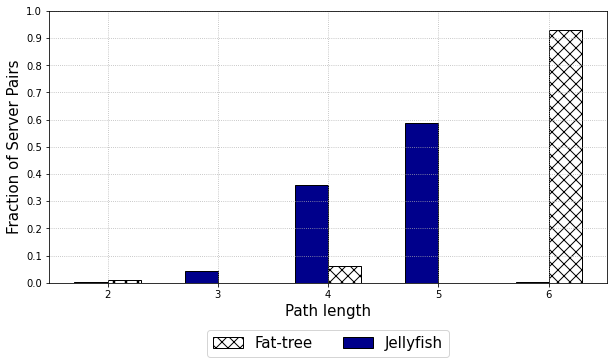

In [16]:
# draw_path_stat(fattree_14_10_means, jellyfish_686_10_means, "figure1(c).png")
draw_path_stat(fattree_14_10_means, jellyfish_686_10_means)

# figure 2 (a) bisection bandwidth

How to compute bisection bandwidth given a topology?

- Bisection bandwidth: sum of the banwidths of the minimal number of links that are cut when splitting the system into two part

In jellyfish paper,

> We normalize bisection bandwidth by dividing it by the total line-rate bandwidth of the servers in one partition.

so we know how to generate normalized bisection bandwidth of figure 2(a).

## Fat tree

There are $k$ pods. Each pod has $\frac{k}{2}$ aggregation switches that are linked to the core layer. So given half the system, there are $\frac{k}{2} \div 2 \times (\frac{k}{2})^2 = \frac{k^3}{8}$ edges between core layer and half of the aggregation layer. (num_aggregation_switches / 2 * num_core_switches)

Number of hosts is $\frac{k}{2} \times k \times \frac{k}{2} = \frac{k^3}{4}$

In [17]:
def normalized_bisection_bw(bisection_bw, line_rate_in_1_part):
    return bisection_bw / line_rate_in_1_part

In [18]:
def fattree_normalized_bisection_bw(N, k):
    num_edges = k ** 3 / 8
    num_hosts = k ** 3 / 4
    normalized_bi_bw = normalized_bisection_bw(num_edges, num_hosts / 2)
    return num_hosts, normalized_bi_bw

In [19]:
fattree_normalized_bisection_bw(N=720, k=32)

(8192.0, 1.0)

## Jellyfish

In the paper, it says
> for Jellyfish, we model the network as a RRG and apply a lower bound of Bollobas.

Referring to Bollobas,
> We shall show that for every $\epsilon > 0$ there is a natural number r such that in almost every r-regular graph of order n, every set of $u \leq \frac{n}{2}$ vertices is joined by at least $(\frac{r}{2} - \epsilon) u$ edges to the rest of the graph.

we can use this lower bound to compute the normalized bisection bandwidth.

Normalized bisection bandwidth = $\frac{N (\frac{r}{4} - \frac{\sqrt{r \ln 2}}{2})}{N (k-r)} = \frac{\frac{r}{4} - \frac{\sqrt{r \ln 2}}{2}}{k-r}$

In [20]:
def jellyfish_normalized_bisection_bw(N, k, r):
    num_edges = N * (r / 4 - np.sqrt(r * np.log(2)) / 2)
    num_hosts = N * (k - r)
    normalized_bi_bw = normalized_bisection_bw(num_edges, num_hosts / 2)
    return num_hosts, normalized_bi_bw

In [21]:
jellyfish_normalized_bisection_bw(2880, 64, 47)

(48960, 1.0466054794077428)

In [22]:
def plot_normalized_bi_bw(outfile=None):
    fig, ax = plt.subplots(figsize=(16,8))
    
    plt.grid(linestyle=':')
    
    # Fat-tree N=720, k=24
    fattree24_x, fattree24_y = fattree_normalized_bisection_bw(N=720, k=24)
    fattree24_x /= 1000
    ax.scatter(fattree24_x, fattree24_y, marker='^', c='black', s=200, label='Fat-tree;N=720;k=24')
    
    # Fat-tree N=1280, k=32
    fattree32_x, fattree32_y = fattree_normalized_bisection_bw(N=1280, k=32)
    fattree32_x /= 1000
    ax.scatter(fattree32_x, fattree32_y, marker='o', c='grey', s=200, label='Fat-tree;N=1280;k=32')
    
    # Fat-tree N=2880, k=48
    fattree48_x, fattree48_y = fattree_normalized_bisection_bw(N=2880, k=48)
    fattree48_x /= 1000
    ax.scatter(fattree48_x, fattree48_y, marker='s', c='red', s=200, label='Fat-tree;N=2880;k=48')
    
    # Jellyfish N=720, k=24
    jellyfish24_x = []
    jellyfish24_y = []
    for r in range(10, 22): # obtain r from figure 2 (a). r ranges from [11, 20]
        x, y = jellyfish_normalized_bisection_bw(720, 24, r)
        jellyfish24_x.append(x / 1000)
        jellyfish24_y.append(y)
    ax.plot(jellyfish24_x, jellyfish24_y, marker='^', markerfacecolor='none', label='Jellyfish;N=720;k=24')

    # Jellyfish N=1280, k=32
    jellyfish32_x = []
    jellyfish32_y = []
    for r in range(13, 28): # obtain r from figure 2 (a). r ranges from [14,26]
        x, y = jellyfish_normalized_bisection_bw(1280, 32, r)
        jellyfish32_x.append(x / 1000)
        jellyfish32_y.append(y)
    ax.plot(jellyfish32_x, jellyfish32_y, marker='o', c='r', markerfacecolor='none', label='Jellyfish;N=1280;k=32')

    # Jellyfish N=2880, k=48
    jellyfish48_x = []
    jellyfish48_y = []
    for r in range(20, 41): # obtain r from figure 2 (a). r ranges from [21, 39]
        x, y = jellyfish_normalized_bisection_bw(2880, 48, r)
        jellyfish48_x.append(x / 1000)
        jellyfish48_y.append(y)
    ax.plot(jellyfish48_x, jellyfish48_y, marker='s', c='b', markerfacecolor='none', label='Jellyfish;N=2880;k=48')

    plt.legend(fontsize=15)
    
    plt.xlabel('Number of Servers in Thousands', fontsize=15)
    plt.ylabel('Normalized Bisection Bandwidth', fontsize=15)
    
    ax.axis(xmin=0, xmax=80)
    ax.axis(ymin=0.2, ymax=1.6)
    
    if outfile:
        plt.savefig(outfile)
    

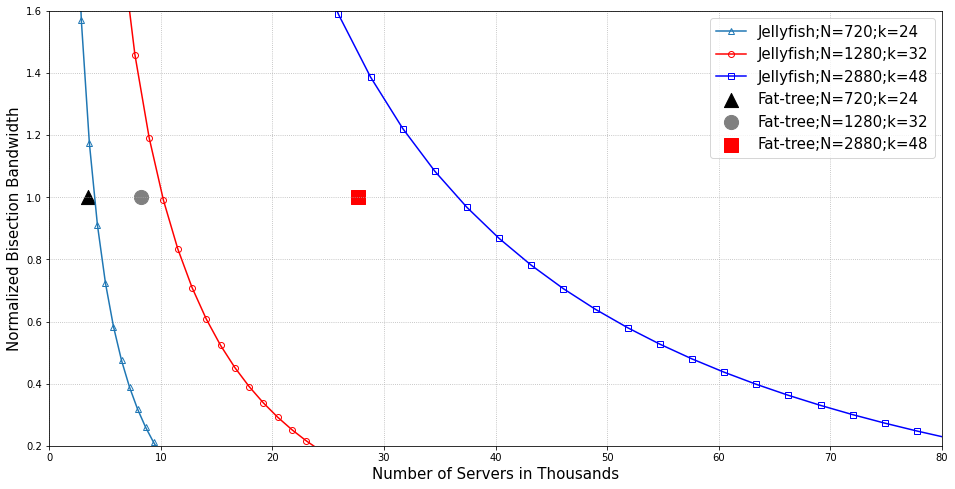

In [23]:
# plot_normalized_bi_bw('figure2(a).png')
plot_normalized_bi_bw()

## figure 2 (b) Equipment cost

For fat tree, given k, we can easily compute number of servers and number of ports:
- number of servers = $\frac{k^3}{4}$
- number of ports = $\frac{5}{4}k^3$

For jellyfish, given port number of a switch, the noramalized bisection bandwidth can be computed as follow:
$$
\frac{N (\frac{r}{4} - \frac{\sqrt{r \ln 2}}{2})}{N (k-r)} = \frac{\frac{r}{4} - \frac{\sqrt{r \ln 2}}{2}}{k-r}
$$
it is a function of $k$ and $r$ regardless of $N$.

Given $k=24, 32, 48, 64$, to get normalized bandwidth $> 1$, we can get the corresponding $r$ value:
- $k=24$: bisection bandwidth $=\frac{\frac{r}{4} - \frac{\sqrt{r \ln 2}}{2}}{24-r}$. $r=19 \to$ bisection bandwidth $=1.174$; $r=18 \to$ bisection bandwidth $=0.911$. So we use $r=19$ to find relation between number of servers and number of ports.
- $k=32$: bisection bandwidth $=\frac{\frac{r}{4} - \frac{\sqrt{r \ln 2}}{2}}{32-r}$. $r=25 \to$ bisection bandwidth $=1.191$; $r=24 \to$ bisection bandwidth $=0.990$. So we use $r=25$ to find relation between number of servers and number of ports.
- $k=48$: bisection bandwidth $=\frac{\frac{r}{4} - \frac{\sqrt{r \ln 2}}{2}}{48-r}$. $r=36 \to$ bisection bandwidth $=1.084$; $r=35 \to$ bisection bandwidth $=0.967$. So we use $r=36$ to find relation between number of servers and number of ports.
- $k=64$: bisection bandwidth $=\frac{\frac{r}{4} - \frac{\sqrt{r \ln 2}}{2}}{64-r}$. $r=47 \to$ bisection bandwidth $=1.047$; $r=46 \to$ bisection bandwidth $=0.964$. So we use $r=47$ to find relation between number of servers and number of ports.

In [24]:
def plot_equipment_cost(outfile=None):
    fig, ax = plt.subplots(figsize=(16, 8))    
    plt.grid(linestyle=':')
    
    # jellyfish 24 ports
    k = 24
    r = 19
    jellyfish24_x = [0, 80]
    jellyfish24_y = []
    for x in jellyfish24_x:
        jellyfish24_y.append(k / (k - r) * x)
    ax.plot(jellyfish24_x, jellyfish24_y, c='#770077', label='Jellyfish;24 ports')
        
    # jellyfish 32 ports
    k = 32
    r = 25
    jellyfish32_x = [0, 80]
    jellyfish32_y = []
    for x in jellyfish32_x:
        jellyfish32_y.append(k / (k - r) * x)
    ax.plot(jellyfish32_x, jellyfish32_y, c='#008800', linewidth=5, label='Jellyfish;32 ports')
        
    # jellyfish 48 ports
    k = 48
    r = 36
    jellyfish48_x = [0, 80]
    jellyfish48_y = []
    for x in jellyfish48_x:
        jellyfish48_y.append(k / (k - r) * x)
    ax.plot(jellyfish48_x, jellyfish48_y, c='#333399', linestyle=":", label='Jellyfish;48 ports')
        
    # jellyfish 64 ports
    k = 64
    r = 47
    jellyfish64_x = [0, 80]
    jellyfish64_y = []
    for x in jellyfish64_x:
        jellyfish64_y.append(k / (k - r) * x)
    ax.plot(jellyfish64_x, jellyfish64_y, c='#FF6600', linewidth=5, label='Jellyfish;64 ports')
        
    # Fat-tree {24,32,48,64} ports
    ports = [24, 32, 48, 64]
    fattree_x = []
    fattree_y = []
    for k in ports:
        fattree_x.append(k ** 3 / 4 / 1000)
        fattree_y.append(k ** 3 * 5 / 4 / 1000)
    ax.scatter(fattree_x, fattree_y, marker='o', c='#CC3333', s=300, label='Fat-tree;{24,32,48,64} ports')
    
    # arrow "Increasing port-count"
    plt.arrow(70, 350, 0, -150, shape='full', length_includes_head=True, linewidth=5, head_width=1, head_length=15, color='black')
    plt.text(60, 170, 'Increasing port-count', fontsize=20)
    
    plt.legend(loc="upper left", fontsize=20)
    
    plt.xlabel('Number of Servers in Thousands', fontsize=20)
    plt.ylabel('Normalized Bisection Bandwidth', fontsize=20)
    
    ax.axis(xmin=0, xmax=80)
    ax.axis(ymin=0, ymax=400)
    
    if outfile:
        plt.savefig(outfile)
    

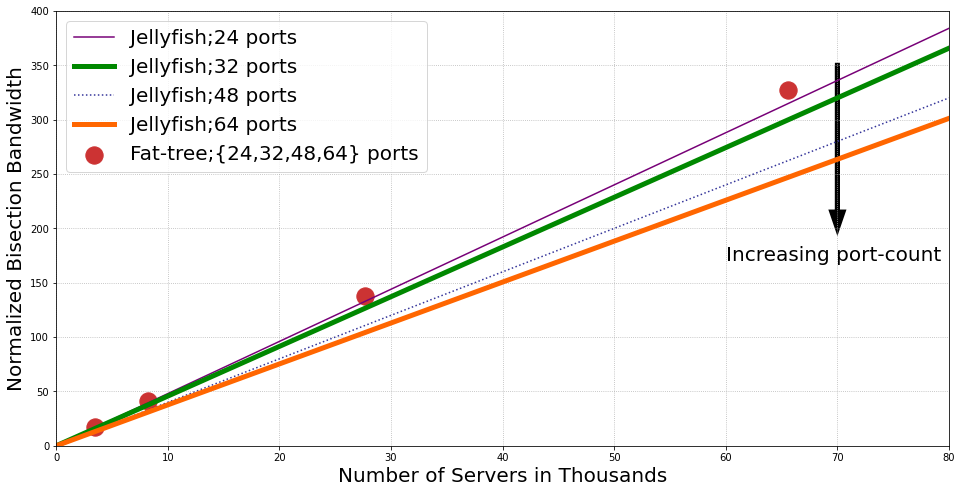

In [25]:
# plot_equipment_cost("figure2(b).png")
plot_equipment_cost()

## distinct path link is on

Figure 9 shows that for "8 Shortest Path", "64-way ECMP" and "8-way ECMP" how many distinct paths a inter-switch link is on. A jellyfish of 686 servers(built using the same equipment as a fat-tree supports 686 servers) is used. 

In [178]:
def random_permutation(num):
    while True:
        p = list(range(num))
        random.shuffle(p)
        for i in range(num):
            if p[i] == i:
                break
        else:
            return tuple(p)

def ecmp_paths(paths, n):
    paths = list(paths)
    for i in range(n - 1):
        if i == len(paths) - 1:
            return paths
        if len(paths[i]) != len(paths[i + 1]):
            return paths[:i + 1]
    return paths[:n]

def add_distinct_paths_count(graph, stat, paths, method):
    for path in paths:
        for i in range(1, len(path) - 1):
            if 'h' in path[i] or 'h' in path[i+1]:
                raise RuntimerError('found hosts')
            stat[(path[i], path[i + 1])][method] += 1
        
def count_paths(graph, traffic, stat):
    for depart, dest in enumerate(traffic):
        depart = f'h{depart}'
        dest = f'h{dest}'
#         print(depart, dest)
        paths = list(islice(nx.shortest_simple_paths(graph, depart, dest), 64))
        k_shortest_paths_8 = [p[1: -1] for p in paths[:8]]
        ecmp_paths_8 = [p[1: -1] for p in ecmp_paths(paths, 8)]
        ecmp_paths_64 = [p[1:-1] for p in ecmp_paths(paths, 64)]
        
        add_distinct_paths_count(graph, stat, k_shortest_paths_8, 'k_shortest_paths_8')
        add_distinct_paths_count(graph, stat, ecmp_paths_8, 'ecmp_paths_8')
        add_distinct_paths_count(graph, stat, ecmp_paths_64, 'ecmp_paths_64')
            

In [186]:
def plot_distinct_paths(graph, outfile=None):
    hosts_set = []
    switches_set = []
    for n in graph.nodes:
        if "h" in n:
            hosts_set.append(n)
        if 's' in n:
            switches_set.append(n)
    
    edge_path_stat = {}
    methods = ['k_shortest_paths_8', 'ecmp_paths_8', 'ecmp_paths_64']
    for edge in graph.edges:
        if 'h' in edge[0] or 'h' in edge[1]:
            continue
        edge_path_stat[(edge[0], edge[1])] = {m: 0 for m in methods}
        edge_path_stat[(edge[1], edge[0])] = {m: 0 for m in methods}
        
    traffic_permutation = random_permutation(len(hosts_set))
    
    count_paths(graph, traffic_permutation, edge_path_stat)
    
    method_count_stat = {}
    for m in methods:
        method_count_stat[m] = []
    for _, v in edge_path_stat.items():
        for m in methods:
            method_count_stat[m].append(v[m])
            
    x = list(range(len(edge_path_stat)))
    for m in methods:
        method_count_stat[m] = sorted(method_count_stat[m])
        
    # plot    
    fig, ax = plt.subplots(figsize=(16, 8))    
    plt.grid(linestyle=':')
    
    ax.plot(x, method_count_stat['k_shortest_paths_8'], label='8 Shortest Paths', c='#333399', linewidth=5)
    ax.plot(x, method_count_stat['ecmp_paths_8'], label='8-way ECMP', c='#00A000')
    ax.plot(x, method_count_stat['ecmp_paths_64'], label='64-way ECMP', c='#CC3333', linestyle=":", linewidth=2)
    
    ax.axis(xmin=0, xmax=3000)
    ax.axis(ymin=0, ymax=18)
    
    plt.legend(loc="upper left", fontsize=20)
    
    plt.xlabel('Rank of Link', fontsize=20)
    plt.ylabel('Distince Paths Link is on', fontsize=20)

    if outfile:
        plt.savefig(outfile)

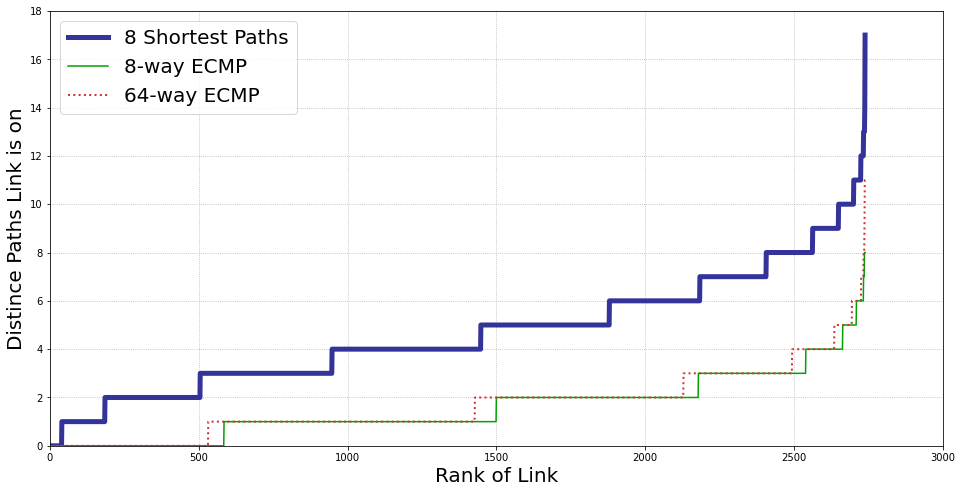

In [187]:
jellyfish686 = build_jellyfish_graph_identical_equipment_as_fattree(245, 230, 14, 3)
# plot_distinct_paths(jellyfish686, "figure 9.png")
plot_distinct_paths(jellyfish686)